> pandas provides a flexible groupby interface, enabling you to slice, dice, and summarize datasets

# 10.1 GroupBy Mechanics

The term **split-apply-combine** is for describing group operations

In the first stage of the process, data contained in a pandas object, is split into groups based on one or more keys that you provide. The splitting is performed on a particular axis of an object

Once this is done, a function is applied to each group, producing a new value. Finally, the results of all those function applications are combined into a result object

See Figure 10-1 for a mockup of a simple group aggregation



<p align='center'>
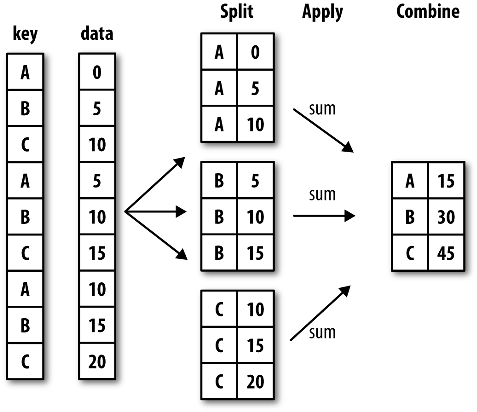
</p>
Figure 10-1. Illustration of a group aggregation

Each grouping key can take many forms, and **the keys do not have to be all of the same type:**

* A **list or array of values that is the same length as the axis being grouped**

* A **value indicating a column name** in a DataFrame

* A **dict or Series giving a correspondence between the values on the axis being grouped and the group names**

* A **function to be invoked on the axis index** or the individual labels in the index

Note that the latter three methods are shortcuts for producing an array of values to be used to split up the object

To get started, here is a small tabular dataset as a DataFrame:

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})

In [3]:
df

,key1,key2,data1,data2
0,a,one,0.741639,1.339147
1,a,two,-1.333859,0.401212
2,b,one,-0.556822,0.600839
3,b,two,-0.799323,0.594490
4,a,one,1.722239,-0.951795


Suppose you wanted to** compute the mean of the data1** column **using the labels from key1**

There are a number of ways to do this. One is to access data1 and call groupby with the column (a Series) at key1:

In [4]:
grouped = df['data1'].groupby(df['key1'])

In [5]:
grouped

This grouped variable is now a **GroupBy object.** **It has not actually computed anything yet** except for some intermediate data about the group key df['key1']

The idea is that **this object has all of the information needed to then apply some operation to each of the groups**

For example, to compute group means we can call the GroupBy’s mean method:



In [6]:
grouped.mean()

key1
a    0.376673
b   -0.678073
Name: data1, dtype: float64

The important thing here is that the data **(a Series) has been aggregated according to the group key, producing a new Series that is now indexed by the unique values in the key1 column**

The result index has the name 'key1' because the DataFrame column df['key1'] did

If instead we had passed multiple arrays as a list, we’d get something different:

In [7]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()

In [8]:
means

key1  key2
a     one     1.231939
      two    -1.333859
b     one    -0.556822
      two    -0.799323
Name: data1, dtype: float64

Here **we grouped the data using two keys, and the resulting Series now has a hierarchical index **consisting of the unique pairs of keys observed:

In [9]:
means.unstack()

key2,one,two
key1,,
a,1.231939,-1.333859
b,-0.556822,-0.799323


In this example, the group keys are all Series, though they could be any arrays of the right length:

In [10]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])

In [11]:
years = np.array([2005, 2005, 2006, 2005, 2006])

In [12]:
df['data1'].groupby([states, years]).mean()

California  2005   -1.333859
            2006   -0.556822
Ohio        2005   -0.028842
            2006    1.722239
Name: data1, dtype: float64

Frequently the grouping information is found in the same DataFrame as the data you want to work on

In that case, **you can pass column names (whether those are strings, numbers, or other Python objects) as the group keys:**

In [13]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,0.376673,0.262855
b,-0.678073,0.597665


You may have noticed in the first case df.groupby('key1').mean() that there is no key2 column in the result

Because df['key2'] is not numeric data, it is said to be a nuisance column, which is therefore excluded from the result



In [14]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one   1.231939  0.193676
     two  -1.333859  0.401212
b    one  -0.556822  0.600839
     two  -0.799323  0.594490

By default, all of the numeric columns are aggregated, though it is possible to filter down to a subset

Regardless of the objective in using groupby, a generally useful GroupBy method is **size**, which **returns a Series containing group sizes:**

In [15]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

Take note that any **missing values in a group key will be excluded from the result**

## Iterating Over Groups

The **GroupBy object supports iteration, generating a sequence of 2-tuples containing the group name along with the chunk of data.** Consider the following:

In [16]:
for name, group in df.groupby('key1'):
  print(name)
  print(group)

a
  key1 key2     data1     data2
0    a  one  0.741639  1.339147
1    a  two -1.333859  0.401212
4    a  one  1.722239 -0.951795
b
  key1 key2     data1     data2
2    b  one -0.556822  0.600839
3    b  two -0.799323  0.594490


In the case of multiple keys, the first element in the tuple will be a tuple of key values:

In [17]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
  print((k1, k2))
  print(group)

('a', 'one')
  key1 key2     data1     data2
0    a  one  0.741639  1.339147
4    a  one  1.722239 -0.951795
('a', 'two')
  key1 key2     data1     data2
1    a  two -1.333859  0.401212
('b', 'one')
  key1 key2     data1     data2
2    b  one -0.556822  0.600839
('b', 'two')
  key1 key2     data1    data2
3    b  two -0.799323  0.59449


Of course, you can choose to do whatever you want with the pieces of data

A recipe you may find useful is computing a dict of the data pieces as a one-liner:

In [18]:
pieces = dict(list(df.groupby('key1')))

In [19]:
pieces['b']

,key1,key2,data1,data2
2,b,one,-0.556822,0.600839
3,b,two,-0.799323,0.594490


By default groupby groups on axis=0, but you can group on any of the other axes

For example, we could **group the columns of our example df here by dtype** like so:

In [20]:
df.dtypes

key1      object
key2      object
data1    float64
data2    float64
dtype: object

In [21]:
grouped = df.groupby(df.dtypes, axis=1)

We can print out the groups like so:

In [22]:
for dtype, group in grouped:
  print(dtype)
  print(group)

float64
      data1     data2
0  0.741639  1.339147
1 -1.333859  0.401212
2 -0.556822  0.600839
3 -0.799323  0.594490
4  1.722239 -0.951795
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


## Selecting a Column or Subset of Columns

**Indexing a GroupBy object created from a DataFrame with a column name** or array of column names has the effect of column subsetting for aggregation

In [23]:
df.groupby('key1')['data1']
df.groupby('key1')['data2']

are syntactic sugar for:

In [24]:
df['data1'].groupby(df['key1'])
df[['data2']].groupby(df['key1'])

Especially for large datasets, it may be **desirable to aggregate only a few columns**

For example, in the preceding dataset, to compute means for just the data2 column and get the result as a DataFrame, we could write:

In [25]:
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one   0.193676
     two   0.401212
b    one   0.600839
     two   0.594490

The object returned by this indexing operation **is a grouped DataFrame if a list or array is passed** or a grouped Series if only a single column name is passed as a scalar:

In [26]:
s_grouped = df.groupby(['key1', 'key2'])['data2']

In [27]:
s_grouped

In [28]:
s_grouped.mean()

key1  key2
a     one     0.193676
      two     0.401212
b     one     0.600839
      two     0.594490
Name: data2, dtype: float64

##Grouping with Dicts and Series

**Grouping information may exist in a form other than an array**

Let’s consider another example DataFrame:

In [29]:
people = pd.DataFrame(np.random.randn(5, 5),
                      columns=['a', 'b', 'c', 'd', 'e'],
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])

In [30]:
people.iloc[2:3, [1, 2]] = np.nan

In [31]:
people

,a,b,c,d,e
Joe,2.023614,1.225152,0.219250,-2.178827,-0.409189
Steve,-0.708288,1.336046,1.445577,0.276924,0.280362
Wes,2.005506,NaN,NaN,1.548844,0.389765
Jim,2.091068,1.806663,0.352310,-0.437619,-2.100584
Travis,-1.182403,0.443653,0.891053,0.193143,0.042884


Now, suppose I have a group correspondence for the columns and want to sum together the columns by group:

In [32]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f': 'orange'}

Now, you could construct an array from this dict to pass to groupby, but **instead we can just pass the dict**

(I included the key 'f' to highlight that unused grouping keys are OK):

In [33]:
by_column = people.groupby(mapping, axis=1)

In [34]:
by_column.sum()

,blue,red
Joe,-1.959577,2.839577
Steve,1.722501,0.908120
Wes,1.548844,2.395271
Jim,-0.085309,1.797146
Travis,1.084195,-0.695866


The same functionality holds for Series, which can be viewed as a fixed-size mapping:

In [35]:
map_series = pd.Series(mapping)

In [36]:
map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [37]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


##Grouping with Functions

Using Python functions is a more generic way of defining a group mapping compared with a dict or Series

**Any function passed as a group key will be called once per index value, with the return values being used as the group names**

More concretely, consider the example DataFrame from the previous section, which has people’s first names as index values

**Suppose you wanted to group by the length of the names;** while you could compute an array of string lengths, it’s simpler to just pass the len function:

In [38]:
people.groupby(len).sum()

,a,b,c,d,e
3,6.120188,3.031815,0.571560,-1.067601,-2.120008
5,-0.708288,1.336046,1.445577,0.276924,0.280362
6,-1.182403,0.443653,0.891053,0.193143,0.042884


Mixing functions with arrays, dicts, or Series is not a problem as everything gets converted to arrays internally:

In [39]:
key_list = ['one', 'one', 'one', 'two', 'two']

In [40]:
people.groupby([len, key_list]).min()

a         b         c         d         e
3 one  2.005506  1.225152  0.219250 -2.178827 -0.409189
  two  2.091068  1.806663  0.352310 -0.437619 -2.100584
5 one -0.708288  1.336046  1.445577  0.276924  0.280362
6 two -1.182403  0.443653  0.891053  0.193143  0.042884

##Grouping by Index Levels

A final convenience for hierarchically indexed datasets is the ability to **aggregate using one of the levels of an axis index.** Let’s look at an example:

In [41]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'],
                                     [1, 3, 5, 1, 3]],
                                    names=['city', 'tenor'])

In [42]:
hier_df = pd.DataFrame(np.random.randn(4, 5), columns=columns)

In [43]:
hier_df

city         US                            JP          
tenor         1         3         5         1         3
0      1.190831 -1.229313 -1.137207 -0.362761  0.882228
1     -0.361260  0.552392 -0.099747  0.491612  0.000784
2      1.604986  1.022740  0.504885  1.262350  1.991626
3      0.694797  1.758531  0.589339  0.314438 -0.816143

**To group by level, pass the level number or name using the level keyword:**

In [44]:
hier_df.groupby(level='city', axis=1).count()

city,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


# 10.2 Data Aggregation

Aggregations refer to any data transformation that produces scalar values from arrays

Many common aggregations, are found in Table 10-1

Table 10-1. Optimized groupby methods
<p align='center'>
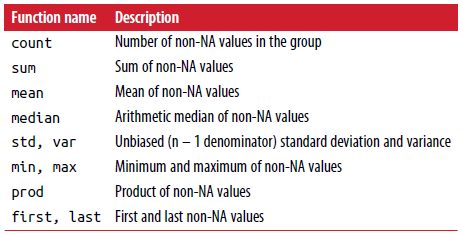
</p>

While **quantile** is not explicitly implemented for GroupBy, it is a Series method and thus available for use

Internally, **GroupBy efficiently slices up the Series, calls piece.quantile(0.9) for each piece,** and then **assembles those results together** into the result object:

In [45]:
df

,key1,key2,data1,data2
0,a,one,0.741639,1.339147
1,a,two,-1.333859,0.401212
2,b,one,-0.556822,0.600839
3,b,two,-0.799323,0.594490
4,a,one,1.722239,-0.951795


In [46]:
grouped = df.groupby('key1')

In [47]:
grouped['data1'].quantile(0.9)

key1
a    1.526119
b   -0.581072
Name: data1, dtype: float64

To use your own aggregation functions, **pass any function that aggregates an array to the aggregate or agg method:**

In [48]:
def peak_to_peak(arr):
  return arr.max() - arr.min()

In [49]:
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,3.056098,2.290941
b,0.242501,0.006349


You may notice that some methods like describe also work, even though they are not aggregations, strictly speaking:

In [50]:
grouped.describe()

data1                      ...     data2                    
     count      mean       std  ...       50%       75%       max
key1                            ...                              
a      3.0  0.376673  1.560395  ...  0.401212  0.870179  1.339147
b      2.0 -0.678073  0.171474  ...  0.597665  0.599252  0.600839

[2 rows x 16 columns]

## Column-Wise and Multiple Function Application

Let’s return to the tipping dataset from earlier examples

After loading it with read_csv, we add a tipping percentage column tip_pct:

In [51]:
!mkdir examples

In [52]:
import urllib.request
url = 'https://raw.githubusercontent.com/wesm/pydata-book/2nd-edition/examples/tips.csv'
filename = 'examples/tips.csv'
urllib.request.urlretrieve(url, filename)

('examples/tips.csv', <http.client.HTTPMessage at 0x7fd0c4c4fe10>)

In [53]:
tips = pd.read_csv('examples/tips.csv')

In [54]:
# Add tip percentage of total bill
tips['tip_pct'] = tips['tip'] / tips['total_bill']

In [55]:
tips[:6]

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
5,25.29,4.71,No,Sun,Dinner,4,0.186240


Aggregating a Series or all of the columns of a DataFrame is a matter of using aggregate with the desired function or calling a method like mean or std

However, you may want to **aggregate using a different function depending on the column, or multiple functions at once**

Fortunately, this is possible to do. First, I’ll group the tips by day and smoker:

In [56]:
grouped = tips.groupby(['day', 'smoker'])

Note that for descriptive statistics like those in Table 10-1, you can pass the name of the function as a string:

In [57]:
grouped_pct = grouped['tip_pct']

In [58]:
grouped_pct.agg('mean')

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

**If you pass a list of functions** or function names instead, **you get back a DataFrame with column names** taken from the functions:

In [59]:
grouped_pct.agg(['mean', 'std', peak_to_peak])

mean       std  peak_to_peak
day  smoker                                  
Fri  No      0.151650  0.028123      0.067349
     Yes     0.174783  0.051293      0.159925
Sat  No      0.158048  0.039767      0.235193
     Yes     0.147906  0.061375      0.290095
Sun  No      0.160113  0.042347      0.193226
     Yes     0.187250  0.154134      0.644685
Thur No      0.160298  0.038774      0.193350
     Yes     0.163863  0.039389      0.151240

Here we passed a list of aggregation functions to agg to evaluate indepedently on the data groups

If you pass a list of (name, function) tuples, the **first element of each tuple will be used as the DataFrame column names**

In [60]:
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

With a DataFrame you have more options, as **you can specify a list of functions to apply to all of the columns or different functions per column**

To start, suppose we wanted to compute the same three statistics for the tip_pct and total_bill columns:

In [61]:
functions = ['count', 'mean', 'max']

In [62]:
result = grouped['tip_pct', 'total_bill'].agg(functions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [63]:
result

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

The resulting DataFrame has hierarchical columns

In [64]:
result['tip_pct']

count      mean       max
day  smoker                           
Fri  No          4  0.151650  0.187735
     Yes        15  0.174783  0.263480
Sat  No         45  0.158048  0.291990
     Yes        42  0.147906  0.325733
Sun  No         57  0.160113  0.252672
     Yes        19  0.187250  0.710345
Thur No         45  0.160298  0.266312
     Yes        17  0.163863  0.241255

As before, a list of tuples with custom names can be passed:

In [65]:
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]

In [66]:
grouped['tip_pct', 'total_bill'].agg(ftuples)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


tip_pct              total_bill            
            Durchschnitt Abweichung Durchschnitt  Abweichung
day  smoker                                                 
Fri  No         0.151650   0.000791    18.420000   25.596333
     Yes        0.174783   0.002631    16.813333   82.562438
Sat  No         0.158048   0.001581    19.661778   79.908965
     Yes        0.147906   0.003767    21.276667  101.387535
Sun  No         0.160113   0.001793    20.506667   66.099980
     Yes        0.187250   0.023757    24.120000  109.046044
Thur No         0.160298   0.001503    17.113111   59.625081
     Yes        0.163863   0.001551    19.190588   69.808518

Now, suppose you wanted to **apply potentially different functions to one or more of the columns**

To do this, **pass a dict to agg that contains a mapping of column names to any of the function specifications listed so far:**

In [67]:
grouped.agg({'tip' : np.max, 'size' : 'sum'})

tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [68]:
grouped.agg({'tip_pct' : ['min', 'max', 'mean', 'std'],
             'size' : 'sum'})

tip_pct                               size
                  min       max      mean       std  sum
day  smoker                                             
Fri  No      0.120385  0.187735  0.151650  0.028123    9
     Yes     0.103555  0.263480  0.174783  0.051293   31
Sat  No      0.056797  0.291990  0.158048  0.039767  115
     Yes     0.035638  0.325733  0.147906  0.061375  104
Sun  No      0.059447  0.252672  0.160113  0.042347  167
     Yes     0.065660  0.710345  0.187250  0.154134   49
Thur No      0.072961  0.266312  0.160298  0.038774  112
     Yes     0.090014  0.241255  0.163863  0.039389   40

A DataFrame will have hierarchical columns only if multiple functions are applied to at least one column

## Returning Aggregated Data Without Row Indexes

The aggregated data comes back with an index, potentially hierarchical, composed from the unique group key combinations

Since this isn’t always desirable, **you can disable this behavior in most cases by passing as_index=False to groupby:**

In [69]:
tips.groupby(['day', 'smoker'], as_index=False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


It’s always possible to obtain the result in this format by calling **reset_index** on the result

In [70]:
tips.groupby(['day', 'smoker']).mean().reset_index()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


# 10.3 Apply: General split-apply-combine

The most general-purpose GroupBy method is apply

As illustrated in Figure 10-1, apply splits the object being manipulated **into pieces, invokes the passed function on each piece,** and then attempts to concatenate the pieces together

Suppose you wanted to select the top five tip_pct values by group

First, write a function that selects the rows with the largest values in a particular column:

In [71]:
def top(df, n=5, column='tip_pct'):
  return df.sort_values(by=column)[-n:]

In [72]:
top(tips, n=6)

,total_bill,tip,smoker,day,time,size,tip_pct
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


Now, if we group by smoker, say, and call apply with this function, we get the following:

In [73]:
tips.groupby('smoker').apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

**The top function is called on each row group from the DataFrame,** and then the results are glued together using pandas.concat, labeling the pieces with the group names

The result therefore has a hierarchical index whose inner level contains index values from the original DataFrame

**If you pass a function to apply that takes other arguments or keywords, you can pass these after the function:**

In [74]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

total_bill    tip smoker   day    time  size   tip_pct
smoker day                                                             
No     Fri  94        22.75   3.25     No   Fri  Dinner     2  0.142857
       Sat  212       48.33   9.00     No   Sat  Dinner     4  0.186220
       Sun  156       48.17   5.00     No   Sun  Dinner     6  0.103799
       Thur 142       41.19   5.00     No  Thur   Lunch     5  0.121389
Yes    Fri  95        40.17   4.73    Yes   Fri  Dinner     4  0.117750
       Sat  170       50.81  10.00    Yes   Sat  Dinner     3  0.196812
       Sun  182       45.35   3.50    Yes   Sun  Dinner     3  0.077178
       Thur 197       43.11   5.00    Yes  Thur   Lunch     4  0.115982

You may recall that I earlier called describe on a GroupBy object:

In [75]:
result = tips.groupby('smoker')['tip_pct'].describe()

In [76]:
result

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,0.159328,0.039910,0.056797,0.136906,0.155625,0.185014,0.291990
Yes,93.0,0.163196,0.085119,0.035638,0.106771,0.153846,0.195059,0.710345


In [77]:
result.unstack('smoker')

       smoker
count  No        151.000000
       Yes        93.000000
mean   No          0.159328
       Yes         0.163196
std    No          0.039910
       Yes         0.085119
min    No          0.056797
       Yes         0.035638
25%    No          0.136906
       Yes         0.106771
50%    No          0.155625
       Yes         0.153846
75%    No          0.185014
       Yes         0.195059
max    No          0.291990
       Yes         0.710345
dtype: float64

Inside GroupBy, when you invoke a method like describe, it is actually just a shortcut for:

In [78]:
f = lambda x: x.describe()
grouped.apply(f)

total_bill       tip  size   tip_pct
day  smoker                                            
Fri  No     count    4.000000  4.000000  4.00  4.000000
            mean    18.420000  2.812500  2.25  0.151650
            std      5.059282  0.898494  0.50  0.028123
            min     12.460000  1.500000  2.00  0.120385
            25%     15.100000  2.625000  2.00  0.137239
...                       ...       ...   ...       ...
Thur Yes    min     10.340000  2.000000  2.00  0.090014
            25%     13.510000  2.000000  2.00  0.148038
            50%     16.470000  2.560000  2.00  0.153846
            75%     19.810000  4.000000  2.00  0.194837
            max     43.110000  5.000000  4.00  0.241255

[64 rows x 4 columns]

## Suppressing the Group Keys

In the preceding examples, you see that the resulting object has a **hierarchical index formed** from the group keys along with the indexes of each piece of the original object

**You can disable this by passing group_keys=False** to groupby:

In [79]:
tips.groupby('smoker', group_keys=False).apply(top)

,total_bill,tip,smoker,day,time,size,tip_pct
88,24.71,5.85,No,Thur,Lunch,2,0.236746
185,20.69,5.00,No,Sun,Dinner,5,0.241663
51,10.29,2.60,No,Sun,Dinner,2,0.252672
149,7.51,2.00,No,Thur,Lunch,2,0.266312
232,11.61,3.39,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


## Quantile and Bucket Analysis

As you may recall from Chapter 8, pandas has some tools, in particular **cut and qcut, for slicing data up into buckets with bins** of your choosing or by sample quantiles

**Combining these functions with groupby** makes it convenient to perform bucket or quantile analysis on a dataset

Consider a simple random dataset and an equal-length bucket categorization using cut:

In [80]:
frame = pd.DataFrame({'data1': np.random.randn(1000),
                      'data2': np.random.randn(1000)})

In [81]:
quartiles = pd.cut(frame.data1, 4)

In [82]:
quartiles[:10]

0    (-1.738, 0.09]
1    (-1.738, 0.09]
2    (-1.738, 0.09]
3    (-1.738, 0.09]
4    (-1.738, 0.09]
5     (0.09, 1.918]
6    (-1.738, 0.09]
7    (-1.738, 0.09]
8    (-1.738, 0.09]
9     (0.09, 1.918]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-3.574, -1.738] < (-1.738, 0.09] < (0.09, 1.918] < (1.918, 3.746]]

**The Categorical object returned by cut can be passed directly to groupby.** So we could compute a set of statistics for the data2 column like so:

In [83]:
def get_stats(group):
  return {'min': group.min(), 'max': group.max(),
          'count': group.count(), 'mean': group.mean()}

In [84]:
grouped = frame.data2.groupby(quartiles)

In [85]:
grouped.apply(get_stats).unstack()

,min,max,count,mean
data1,,,,
"(-3.574, -1.738]",-2.403595,1.867259,49.0,-0.271052
"(-1.738, 0.09]",-2.643592,2.804308,499.0,0.029550
"(0.09, 1.918]",-3.896612,2.829502,423.0,-0.014092
"(1.918, 3.746]",-2.442804,3.017647,29.0,0.202661


These were equal-length buckets; **to compute equal-size buckets based on sample quantiles, use qcut.** I’ll pass labels=False to just get quantile numbers:

In [86]:
# Return quantile numbers
grouping = pd.qcut(frame.data1, 10, labels=False)

In [87]:
grouped = frame.data2.groupby(grouping)

In [88]:
grouped.apply(get_stats).unstack

<bound method Series.unstack of data1       
0      min       -2.403595
       max        2.596569
       count    100.000000
       mean       0.053658
1      min       -2.225340
       max        2.552300
       count    100.000000
       mean       0.000652
2      min       -2.383560
       max        2.804308
       count    100.000000
       mean      -0.124971
3      min       -2.402165
       max        2.640892
       count    100.000000
       mean       0.186174
4      min       -2.432143
       max        2.528223
       count    100.000000
       mean      -0.033651
5      min       -3.896612
       max        2.028627
       count    100.000000
       mean      -0.042509
6      min       -2.720129
       max        2.829502
       count    100.000000
       mean      -0.002313
7      min       -2.761104
       max        1.849470
       count    100.000000
       mean       0.105401
8      min       -2.358615
       max        2.232681
       count    100.000000
       mea

## Example: Filling Missing Values with Group-Speciic Values

When cleaning up missing data, in some cases you will replace data observations using dropna, but in others **you may want to impute (fill in) the null (NA) values using a fixed value or some value derived from the data**

fillna is the right tool to use; for example, here I fill in NA values with the mean:

In [89]:
s = pd.Series(np.random.randn(6))

In [90]:
s[::2] = np.nan

In [91]:
s

0         NaN
1    1.883763
2         NaN
3    0.869225
4         NaN
5    0.728236
dtype: float64

In [92]:
s.fillna(s.mean())

0    1.160408
1    1.883763
2    1.160408
3    0.869225
4    1.160408
5    0.728236
dtype: float64

Suppose you need the fill value to vary by group

One way to do this is to **group the data and use apply with a function that calls fillna on each data chunk** 

Here is some sample data on US states divided into eastern and western regions:

In [93]:
states = ['Ohio', 'New York', 'Vermont', 'Florida',
          'Oregon', 'Nevada', 'California', 'Idaho']

In [94]:
group_key = ['East'] * 4 + ['West'] * 4

In [95]:
data = pd.Series(np.random.randn(8), index=states)

In [96]:
data

Ohio         -0.287823
New York     -0.905449
Vermont      -1.956676
Florida      -0.883063
Oregon       -0.031364
Nevada        0.416550
California    0.670154
Idaho         0.176735
dtype: float64

Let’s set some values in the data to be missing:

In [97]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan

In [98]:
data

Ohio         -0.287823
New York     -0.905449
Vermont            NaN
Florida      -0.883063
Oregon       -0.031364
Nevada             NaN
California    0.670154
Idaho              NaN
dtype: float64

In [99]:
data.groupby(group_key).mean()

East   -0.692112
West    0.319395
dtype: float64

We can **fill the NA values using the group means** like so:

In [100]:
fill_mean = lambda g: g.fillna(g.mean())

In [101]:
data.groupby(group_key).apply(fill_mean)

Ohio         -0.287823
New York     -0.905449
Vermont      -0.692112
Florida      -0.883063
Oregon       -0.031364
Nevada        0.319395
California    0.670154
Idaho         0.319395
dtype: float64

In another case, you might have predefined **fill values in your code that vary by group**

Since the groups have a name attribute set internally, we can use that:

In [102]:
fill_values = {'East': 0.5, 'West': -1}

In [103]:
fill_func = lambda g: g.fillna(fill_values[g.name])

In [104]:
data.groupby(group_key).apply(fill_func)

Ohio         -0.287823
New York     -0.905449
Vermont       0.500000
Florida      -0.883063
Oregon       -0.031364
Nevada       -1.000000
California    0.670154
Idaho        -1.000000
dtype: float64

## Example: Random Sampling and Permutation

Suppose you wanted to **draw a random sample** (with or without replacement) **from a large dataset for Monte Carlo simulation** purposes or some other application

There are a number of ways to **perform the “draws”;** here we use the **sample method** for Series

To demonstrate, here’s a way to **construct a deck of English-style playing cards:**

In [105]:
# Hearts, Spades, Clubs, Diamonds
suits = ['H', 'S', 'C', 'D']
card_val = (list(range(1, 11)) + [10] * 3) * 4
base_names = ['A'] + list(range(2, 11)) + ['J', 'K', 'Q']
cards = []
for suit in ['H', 'S', 'C', 'D']:
  cards.extend(str(num) + suit for num in base_names)

deck = pd.Series(card_val, index=cards)

So now we have a Series of length 52 whose index contains card names and values are the ones used in Blackjack and other games

To keep things simple, I just let the ace 'A' be 1:

In [106]:
deck[:13]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
dtype: int64

Now, based on what I said before, **drawing a hand of five cards from the deck** could be written as:

In [107]:
def draw(deck, n=5):
  return deck.sample(n)

In [108]:
draw(deck)

9H    9
7C    7
2H    2
5H    5
4S    4
dtype: int64

Suppose you wanted **two random cards from each suit** 

Because the **suit is the last character of each card name, we can group based on this and use apply:**

In [109]:
get_suit = lambda card: card[-1] # last letter is suit

In [110]:
deck.groupby(get_suit).apply(draw, n=2)

C  8C     8
   JC    10
D  9D     9
   QD    10
H  6H     6
   AH     1
S  7S     7
   4S     4
dtype: int64

Alternatively, we could write:

In [111]:
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

9C     9
8C     8
QD    10
4D     4
AH     1
4H     4
JS    10
6S     6
dtype: int64

## Example: Group Weighted Average and Correlation

Under the split-apply-combine paradigm of groupby, **operations between columns in a DataFrame or two Series, such as a group weighted average, are possible**

As an example, take this **dataset containing group keys, values, and some weights:**

In [112]:
df = pd.DataFrame({'category': ['a', 'a', 'a', 'a',
                                'b', 'b', 'b', 'b'],
                   'data': np.random.randn(8),
                   'weights': np.random.randn(8)})

In [113]:
df

,category,data,weights
0,a,-0.288344,0.471215
1,a,-0.618730,0.329986
2,a,1.035298,0.320622
3,a,0.092329,1.636964
4,b,-0.883823,-0.339712
5,b,2.200100,-0.300884
6,b,2.369340,0.659863
7,b,0.495282,0.779809


The group weighted average by category would then be:

In [114]:
grouped = df.groupby('category')

In [115]:
get_wavg = lambda g: np.average(g['data'], weights=g['weights'])

In [116]:
grouped.apply(get_wavg)

category
a    0.051847
b    1.987216
dtype: float64

As another example, consider a financial dataset originally obtained from Yahoo! Finance containing end-of-day prices for a few stocks and the S&P 500 index (the SPX symbol):

In [117]:
url = 'https://raw.githubusercontent.com/wesm/pydata-book/2nd-edition/examples/stock_px_2.csv'
filename = 'examples/stock_px_2.csv'
urllib.request.urlretrieve(url, filename)

('examples/stock_px_2.csv', <http.client.HTTPMessage at 0x7fd0c44f5050>)

In [118]:
close_px = pd.read_csv('examples/stock_px_2.csv', parse_dates=True,
                       index_col=0)

In [119]:
close_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2214 non-null   float64
 1   MSFT    2214 non-null   float64
 2   XOM     2214 non-null   float64
 3   SPX     2214 non-null   float64
dtypes: float64(4)
memory usage: 86.5 KB


In [120]:
close_px[-4:]

,AAPL,MSFT,XOM,SPX
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66
2011-10-14,422.00,27.27,78.11,1224.58


One task of interest might be to compute a DataFrame consisting of the **yearly correlations of daily returns (computed from percent changes) with SPX**

As one way to do this, we **first create a function that computes the pairwise correlation** of each column **with the 'SPX' column:**

In [121]:
spx_corr = lambda x: x.corrwith(x['SPX'])

Next, we compute percent change on close_px using pct_change:

In [122]:
rets = close_px.pct_change().dropna()

Lastly, we **group these percent changes by year,** which can be extracted from each row label with a one-line function that returns the year attribute of each datetime label:

In [123]:
get_year = lambda x : x.year

In [124]:
by_year = rets.groupby(get_year)

In [125]:
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


You could also compute **inter-column correlations.** Here we compute the **annual correlation between Apple and Microsoft:**

In [126]:
by_year.apply(lambda g: g['AAPL'].corr(g['MSFT']))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

## Example: Group-Wise Linear Regression

In the same theme as the previous example, you can use groupby to perform more complex group-wise statistical analysis, as long as the function returns a pandas object or scalar value

For example, I can define the following regress function (using the statsmodels econometrics library), which **executes an ordinary least squares (OLS) regression on each chunk of data:**

In [127]:
import statsmodels.api as sm
def regress(data, yvar, xvars):
  Y = data[yvar]
  X = data[xvars]
  X['intercept'] = 1.
  result = sm.OLS(Y, X).fit()
  return result.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Now, to run a **yearly linear regression of AAPL on SPX returns, execute:**

In [128]:
by_year.apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


# 10.4 Pivot Tables and Cross-Tabulation

A **pivot table is a data summarization tool** frequently found in spreadsheet programs and other data analysis software

It **aggregates a table of data by one or more keys, arranging the data in a rectangle** with some of the group keys along the rows and some along the columns

Pivot tables in Python with pandas are made possible through the **groupby** facility described in this chapter combined with **reshape** operations utilizing hierarchical indexing

DataFrame has a **pivot_table** method, and there is also a top-level pandas.pivot_table function

In addition to providing a convenience interface to groupby, **pivot_table can add partial totals, also known as margins**

Returning to the tipping dataset, suppose you wanted to **compute a table of group means** (the default pivot_table aggregation type) arranged by day and smoker on the rows:

In [129]:
tips.pivot_table(index=['day', 'smoker'])

size       tip   tip_pct  total_bill
day  smoker                                          
Fri  No      2.250000  2.812500  0.151650   18.420000
     Yes     2.066667  2.714000  0.174783   16.813333
Sat  No      2.555556  3.102889  0.158048   19.661778
     Yes     2.476190  2.875476  0.147906   21.276667
Sun  No      2.929825  3.167895  0.160113   20.506667
     Yes     2.578947  3.516842  0.187250   24.120000
Thur No      2.488889  2.673778  0.160298   17.113111
     Yes     2.352941  3.030000  0.163863   19.190588

This could have been produced with groupby directly

Now, suppose we want to **aggregate only tip_pct and size, and additionally group by time**

**I’ll put smoker in the table columns and day in the rows:**

In [130]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'],
                 columns='smoker')

size             tip_pct          
smoker             No       Yes        No       Yes
time   day                                         
Dinner Fri   2.000000  2.222222  0.139622  0.165347
       Sat   2.555556  2.476190  0.158048  0.147906
       Sun   2.929825  2.578947  0.160113  0.187250
       Thur  2.000000       NaN  0.159744       NaN
Lunch  Fri   3.000000  1.833333  0.187735  0.188937
       Thur  2.500000  2.352941  0.160311  0.163863

We could augment this table to include **partial totals by passing margins=True**

This has the effect of **adding All row and column labels**, with corresponding values being the group statistics for all the data within a single tier:

In [131]:
tips.pivot_table(['size', 'tip_pct'], index=['time', 'day'], 
                 columns=['smoker'], margins=True)

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
time   day                                                             
Dinner Fri   2.000000  2.222222  2.166667  0.139622  0.165347  0.158916
       Sat   2.555556  2.476190  2.517241  0.158048  0.147906  0.153152
       Sun   2.929825  2.578947  2.842105  0.160113  0.187250  0.166897
       Thur  2.000000       NaN  2.000000  0.159744       NaN  0.159744
Lunch  Fri   3.000000  1.833333  2.000000  0.187735  0.188937  0.188765
       Thur  2.500000  2.352941  2.459016  0.160311  0.163863  0.161301
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

Here, the **All values are means** without taking into account smoker versus non smoker (the All columns) or any of the two levels of grouping on the rows (the All row)

To use a **different aggregation function,** pass it to **aggfunc.** For example, **'count'** or len will give you a cross-tabulation (count or frequency) of group sizes:

In [135]:
tips.pivot_table('tip_pct', index=['time', 'smoker'], columns='day', 
                 aggfunc=len, margins=True)

day             Fri   Sat   Sun  Thur    All
time   smoker                               
Dinner No       3.0  45.0  57.0   1.0  106.0
       Yes      9.0  42.0  19.0   NaN   70.0
Lunch  No       1.0   NaN   NaN  44.0   45.0
       Yes      6.0   NaN   NaN  17.0   23.0
All            19.0  87.0  76.0  62.0  244.0

If some combinations are **empty** (or otherwise NA), you may wish to pass a **fill_value:**

In [138]:
tips.pivot_table('tip_pct', index=['time', 'size', 'smoker'],
                 columns='day', aggfunc='mean', fill_value=0)

day                      Fri       Sat       Sun      Thur
time   size smoker                                        
Dinner 1    No      0.000000  0.137931  0.000000  0.000000
            Yes     0.000000  0.325733  0.000000  0.000000
       2    No      0.139622  0.162705  0.168859  0.159744
            Yes     0.171297  0.148668  0.207893  0.000000
       3    No      0.000000  0.154661  0.152663  0.000000
            Yes     0.000000  0.144995  0.152660  0.000000
       4    No      0.000000  0.150096  0.148143  0.000000
            Yes     0.117750  0.124515  0.193370  0.000000
       5    No      0.000000  0.000000  0.206928  0.000000
            Yes     0.000000  0.106572  0.065660  0.000000
       6    No      0.000000  0.000000  0.103799  0.000000
Lunch  1    No      0.000000  0.000000  0.000000  0.181728
            Yes     0.223776  0.000000  0.000000  0.000000
       2    No      0.000000  0.000000  0.000000  0.166005
            Yes     0.181969  0.000000  0.000000  0.158843
       3    No      0.187735  0.000000  0.000000  0.084246
            Yes     0.000000  0.000000  0.000000  0.204952
       4    No      0.000000  0.000000  0.000000  0.138919
            Yes     0.000000  0.000000  0.000000  0.155410
       5    No      0.000000  0.000000  0.000000  0.121389
       6    No      0.000000  0.000000  0.000000  0.173706

See Table 10-2 for a summary of pivot_table methods

Table 10-2. pivot_table options
<p align='center'>
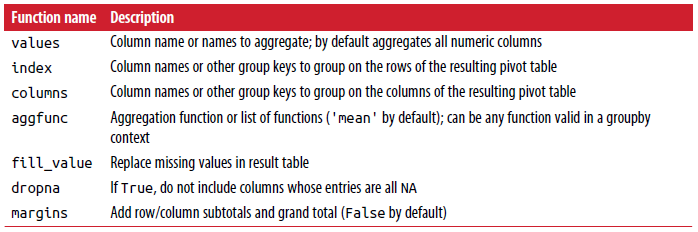
</p>

## Cross-Tabulations: Crosstab

A cross-tabulation (or **crosstab** for short) is a special case of a pivot table that **computes group frequencies.** Here is an example:

In [177]:
sample = np.arange(1, 11)
nationality = ['USA', 'Japan', 'USA'] + ['Japan'] * 3 + \
              ['USA'] * 2 + ['Japan', 'USA']
handedness = ['Right-handed'] + \
             ['Left-handed', 'Right-handed', 'Right-handed'] * 3          
data = pd.DataFrame({'Sample': sample, 'Nationality': nationality, 
                     'Handedness': handedness})

In [178]:
data

,Sample,Nationality,Handedness
0,1,USA,Right-handed
1,2,Japan,Left-handed
2,3,USA,Right-handed
3,4,Japan,Right-handed
4,5,Japan,Left-handed
5,6,Japan,Right-handed
6,7,USA,Right-handed
7,8,USA,Left-handed
8,9,Japan,Right-handed
9,10,USA,Right-handed


As part of some survey analysis, we might want to **summarize this data by nationality and handedness**

You could use pivot_table to do this, but the pandas.crosstab function can be more convenient:

In [180]:
pd.crosstab(data.Nationality, data.Handedness, margins=True)

Handedness,Left-handed,Right-handed,All
Nationality,,,
Japan,2,3,5
USA,1,4,5
All,3,7,10


The **first two arguments to crosstab can each either be an array or Series or a list of arrays.** As in the tips data:

In [181]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244